In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [2]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [4]:
v = stepmodel.read_json(model_path + 'de_volumes')
sm.volumes = v.volumes

In [5]:
sm.segments = [c for c in sm.volumes.columns if c not in ['origin', 'destination']]

In [6]:
road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [7]:
car = stepmodel.read_json(model_path + 'de_road_los')
pt = stepmodel.read_json(model_path + 'de_pt_los')

In [8]:
# Rename columns that were confused through json export
column_dict = {"('"+seg+"', 'probability')": (seg, 'probability') for seg in sm.segments}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [9]:
# Load logit step probabilities to enrich LoS tables
'''logit = stepmodel.read_json(model_path + 'de_logit')
probs = logit.probabilities.set_index(['origin', 'destination', 'segment'])[
    ['walk', 'car', 'air', 'bus', 'coach', 'rail_short', 'rail_long']
].stack().rename('probability').unstack('segment')
probs.index.rename(['origin', 'destination', 'route_type'], inplace=True)

sm.pt_los = pt.pt_los.merge(probs, how='left',
    on=['origin', 'destination', 'route_type']
).rename(columns={seg: (seg, 'probability') for seg in sm.segments})

sm.car_los = car.car_los.merge(probs, how='left',
    on=['origin', 'destination', 'route_type']
).rename(columns={seg: (seg, 'probability') for seg in sm.segments})'''
print('This step is necessary if enriched LoS tables were not saved in the logit step')

This step is necessary if enriched LoS tables were not saved in the logit step


In [10]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [11]:
sm.pt_los.sample(2)

,access_time,accessibility,destination,footpath_time,gc,gc_d,in_vehicle_time,length,link_path,mode_utility,...,"('Fz1', 'utility')","('Fz2', 'utility')","('Fz3', 'utility')","('Fz4', 'utility')","('Fz6', 'utility')","(Fz1, probability)","(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)"
index,,,,,,,,,,,,,,,,,,,,,
264409,2111,0.656853,DE224,4843,NaN,NaN,31200,824690,"(coach_362, coach_363, coach_12111, coach_12112)",-3.825838,...,-13.428815,-12.411251,-16.804973,-6.911974,-10.030066,0.000004,0.001267,0.000001,0.000211,0.000521
128609,1796,0.000000,DE258,0,NaN,NaN,2258,126296,"(r_s_19541, r_s_142423, r_s_142424, r_s_142425...",-2.131364,...,-2.660946,-1.472989,-3.809075,-2.729040,-3.191797,0.032265,0.076975,0.010632,0.029524,0.030239


In [12]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

## Assignment

In [13]:
# Generate loaded links and nodes from pt_los and volumes
sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [01:12<00:00, 14.60s/it]


In [14]:
# Generate road_links loads from car_los and volumes
sm.segmented_car_assignment()

Fz6: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.36s/it]


In [15]:
# Assign volumes to LoS path table
sm.compute_los_volume(keep_segments=True)

## Results

In [16]:
sm.loaded_links.loc[sm.loaded_links['load']!=0].sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway,price,route_type_disagg,boarding_time,"(load, bus)","(load, coach)","(load, rail_long)","(load, rail_short)","(load, air)","(load, walk)",load
index,,,,,,,,,,,,,,,,,,,,
r_l_4468,r_l_n_210,r_l_n_1075,rail_long,"LINESTRING (8.66415 49.29135, 8.58965 49.12462)",13,rail_long_3,660,rail_long_742,22127,2400,2.20595,rail_long,1800,0.0,0.0,56013.720565,0.0,0.0,0.0,56013.720565


In [17]:
sm.road_links.loc[sm.road_links[('all', 'car')]!=0].sample()

,a,b,maxspeed,length,time,geometry,lanes,"(Fz1, car)","(Fz2, car)","(Fz3, car)","(Fz4, car)","(Fz6, car)","(all, car)"
index,,,,,,,,,,,,,
rl_425073,405370021,148680374,50,40,3,"LINESTRING (13.41191 48.57376, 13.41157 48.57347)",None,6.168681e+06,645003.740099,1.450106e+06,1.430840e+06,2.146820e+06,1.184145e+07


In [18]:
sm.los.sample()

,index,access_time,accessibility,destination,footpath_time,gc,gc_d,in_vehicle_time,length,link_path,...,"(Fz2, probability)","(Fz3, probability)","(Fz4, probability)","(Fz6, probability)",Fz1,Fz2,Fz3,Fz4,Fz6,volume
412411,429189,1230,0.079565,DEA54,182,NaN,NaN,14496,572621,"(r_s_116522, r_s_116524, r_s_116525, r_s_11652...",...,0.095592,0.012215,0.091043,0.055875,0.0,0.0,0.0,11.653509,31.290029,42.943538


<AxesSubplot:>

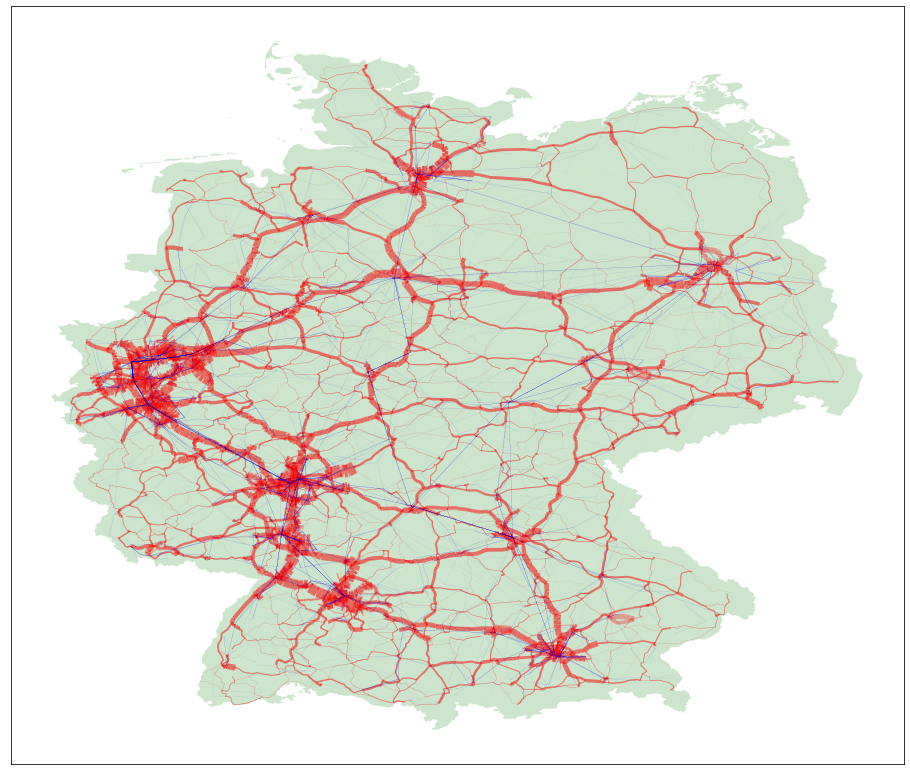

In [19]:
# Plot road and PT assignment
sm.loaded_links = gpd.GeoDataFrame(sm.loaded_links)
sm.road_links = gpd.GeoDataFrame(sm.road_links)
scaler = max(sm.loaded_links['load'].max(), sm.road_links[('all', 'car')].max()) / 35
sm.loaded_links.plot(alpha=.3, color='blue', linewidth=list(sm.loaded_links['load']/scaler),
    ax=sm.road_links.plot(alpha=.3, color='red', linewidth=list(sm.road_links[('all', 'car')]/scaler),
        ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16))))

<AxesSubplot:>

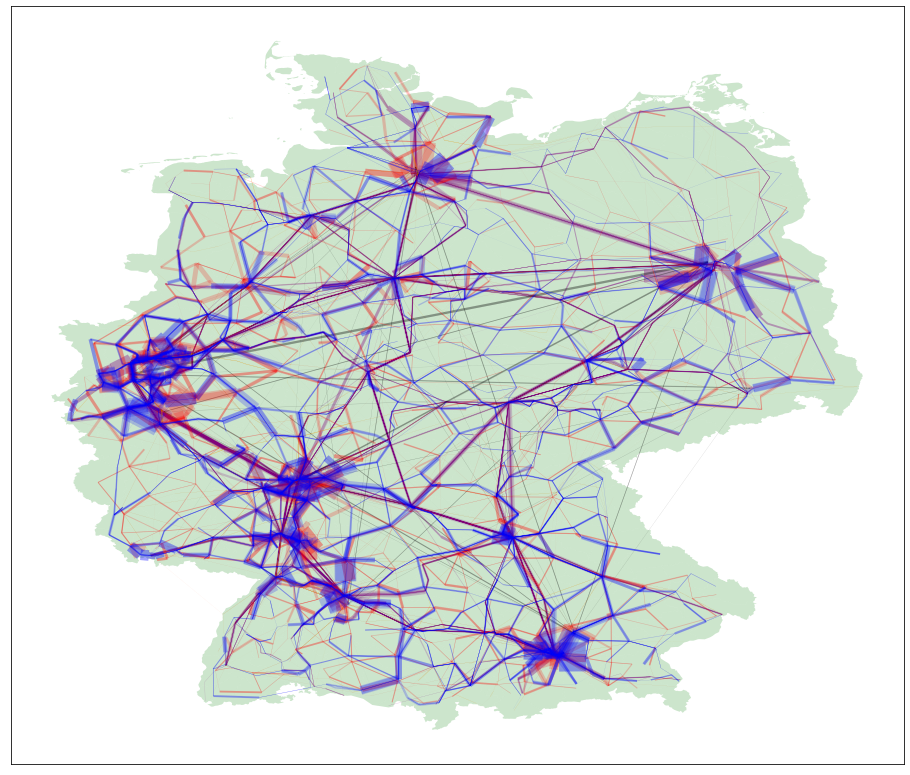

In [20]:
# Only PT
colors = sm.loaded_links['route_type'].map(
    {'rail_long': 'purple', 'rail_short': 'blue', 'bus': 'red', 'coach': 'orange', 'air': 'black'})
sm.loaded_links.plot(alpha=.2, color=list(colors),
    linewidth=list(sm.loaded_links['load']/sm.loaded_links['load'].max()*30),
    ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16)))

### Validation

In [21]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

In [22]:
diff['diff'].mean()

3.8559608343217065e-08

<AxesSubplot:>

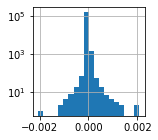

In [23]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [24]:
# Summary of LoS table volumes
od_sum = sm.summary_od(costs=[])

In [25]:
od_sum.sample()

,,segment,Fz1,Fz2,Fz3,Fz4,Fz6,root
,,sum,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,
DE225,DEG0M,coach,0.0,0.0,0.0,0.038109,2.290023,2.328132


In [26]:
# Add averages from following attributes
attrs = ['price', # EUR per person
         'time', # hours per trip
         'in_vehicle_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type'])[attrs].mean()
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [27]:
# Convert units
od_sum[('root', 'length')] /= 1000
od_sum[('root', 'in_vehicle_time')] /= 3600

In [28]:
# Compute passenger kilometer
for seg in sm.segments + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

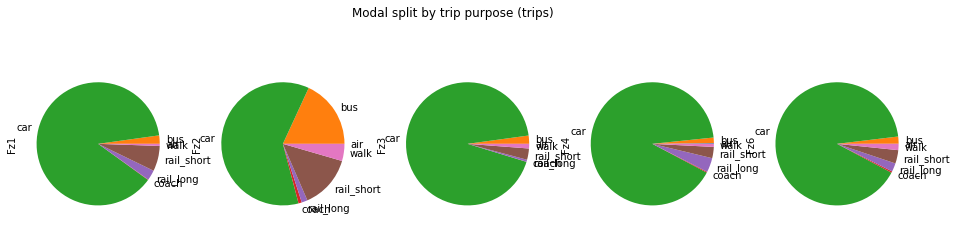

In [29]:
od_sum.loc[:, [(seg, 'volume') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

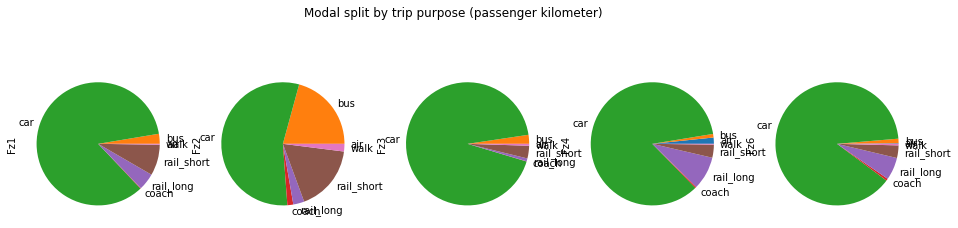

In [30]:
od_sum.loc[:, [(seg, 'pkm') for seg in sm.segments]].groupby(level=2).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

Volumes by mode and distance class


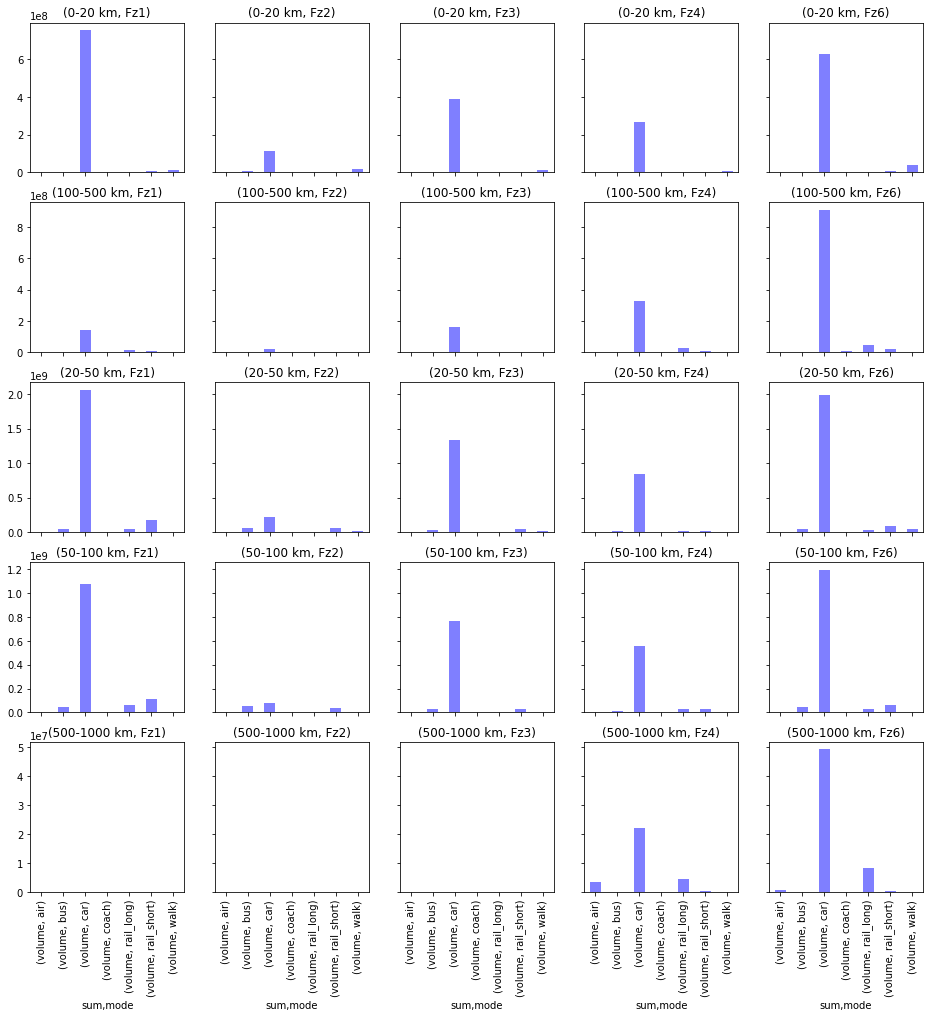

In [31]:
od = od_sum[[(seg, 'volume') for seg in sm.segments]].unstack('mode')
bins = [0, 20, 50, 100, 500, 1000]
distances = sm.car_los.drop_duplicates(['origin', 'destination']).set_index(
    ['origin', 'destination'])['length'] / 1000
od['bins'] = pd.cut(od.merge(distances, how='left', left_index=True,
                             right_index=True)['length'], bins=bins,
                    labels=['{}-{} km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)])
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,16), sharex='all', sharey='row')
od.sort_values('bins').groupby('bins').sum(axis=0).stack('segment').T.plot.bar(
    ax=ax, subplots=True, legend=False, color='blue', alpha=0.5)
print('Volumes by mode and distance class')

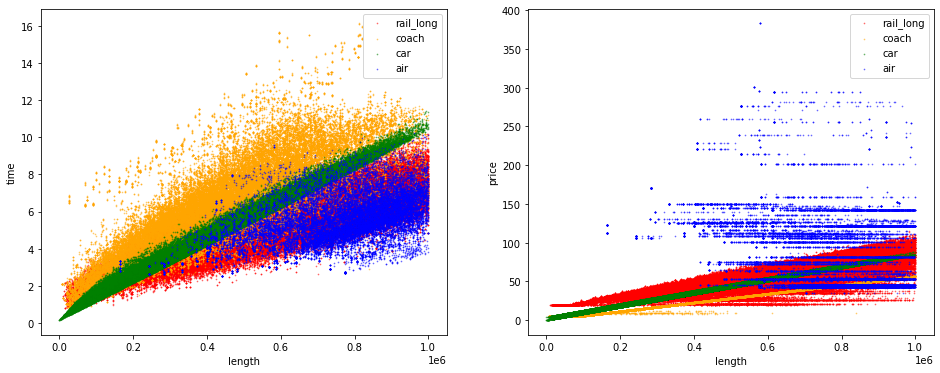

In [32]:
# How do the LoS attributes look like again?
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
c_dict = {'rail_long': 'red', 'coach': 'orange', 'car': 'green', 'air': 'blue'}
for m in c_dict.keys():
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[0], kind='scatter', x='length', y='time', s=.5, c=c_dict[m], alpha=.5, label=m)
    sm.los.loc[sm.los['route_type']==m].plot(
        ax=ax[1], kind='scatter', x='length', y='price', s=.5, c=c_dict[m], alpha=.5, label=m)
plt.legend()

### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [33]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [34]:
# Aggregated modal split in million pkm
od.groupby(level=2).sum(axis=1)['pkm'] / 1e6

mode
air             3605.241505
bus            21436.324151
car           834758.231442
coach           3764.632158
rail_long      51387.324452
rail_short     45992.023194
walk            3832.005287
Name: pkm, dtype: float64

In [35]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [36]:
# Calculate weighted averages by zone aggregation
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    price=('price', weighted_av),
    time=('time', weighted_av),
    in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av))

In [37]:
with pd.ExcelWriter(output_path + 'inter_zone.xlsx') as writer:  
    od.to_excel(writer, sheet_name='od')

## Save model

In [38]:
sm.to_json(model_path + 'de_assignment', only_attributes=[
    'loaded_links', 'loaded_nodes', 'road_links'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [03:04<00:00,  4.85s/it]
